# **Implementing a GPT Model to Generate Text** 

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.3
torch version: 2.7.0
tiktoken version: 0.9.0


## **1. Coding An LLM Architecture**

- In this notebook, we'll be working on developing the base architecture of a "decoder-like" LLM. This architecture has been used in leading LLMs like GPT and Llama and is demonstrably different than CNNs and traditional deep learning approaches, primarily due to the vast number of parameters.
- Sticking with the principle that _There are no solutions, only trade-offs_, let's assume that this architecture, though extremely powerful at scale, also has serious downsides. I'll link papers discussing this in a separate section of this repo.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240712150234/GPT-Arcihtecture.webp" width="640px">

- Compared to previous NBs, we'll be moving towards increasing embedding and model sizes to match models like GPT-2 (which has 124 million parameters.)

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False # To include/exclude a bias vector when computing QKV tensors.
                      #Setting is standard to modern LLMs but will be revisited later.
}

- The `DummyGPTModel` class is a simplified version of a GPT-style model.
- It consists of token embeddings, positional embeddings, drop out, transformer blocks (`DummyTransformerBlock`), layer normalization (`DummyLayerNorm`) and a linear output layer (`out_head`).

In [3]:
import torch
import torch.nn as nn 

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Placeholder for transformer block
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Placeholder for layer norm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Simple placeholder
    
    def forward(self, x):
        # Only returns the inputs
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # These parameters mimic the LayerNorm interface
        
    def forward(self, x):
        # Only returns inputs
        return x

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

Output shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## **2. Normalizing Activations with Layer Norm**

- Layer normalization basically centers the activations of a NN layer around a mean of 0 and variance of 1 to allow for stable training and faster convergence to effective weights.
- This normalization is applied both before and after the multi-head attention module within a transformer block and once before the final output layer.

In [6]:
torch.manual_seed(123)

# 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
# Computing the mean and variance for each of the 2 inputs
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Using the above, we can now implement a `LayerNorm` class.
- `Scale` and `Shift` are two trainable parameters which the LLM automatically adjusts during training based on the model's perfomance. 
- With regard to **Biased Variance**, we set `unbiased=False` with a view that the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute variance doesn't include Bessel's correction. This correction uses `n-1` in the denominator. Also, GPT-2 was trained with biased variance in the normalization layers.

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # small constant added to the denominator to avoid div by zero errors.
        self.scale = nn.Parameter(torch.ones(emb_dim)) # multiply by one
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # add 0
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## **3. Implementing a Feed-Forward Network with GELU Activations**

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x* (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

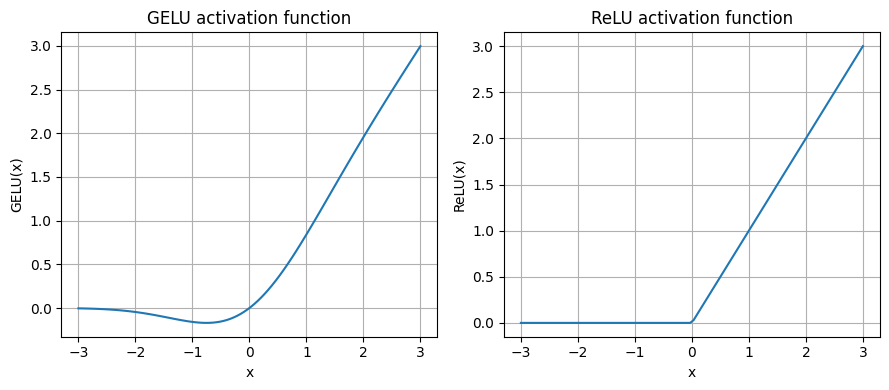

In [15]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Generate some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(9, 4))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show();

In [16]:
# Implementing a small neural network module to be used later in the LLM's transformer block
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [17]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [18]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_tokens, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## **4. Adding Skip Connections**

In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check whether the shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    

def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss 
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [20]:
# Printing gradients without shortcut connections
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [21]:
# Printing gradients with shortcut connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## **5. Connecting Attention and Linear Layers in a Transformer Block**

In [24]:
from utils.components import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Skip connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        # Skip connection for FF block
        shortcut = x 
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Adding the original input back

        return x


In [25]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768) # [bs, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape: ", x.shape)
print("Output shape: ", output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])
